In [1]:
!pip install -q -U watermark
!pip install -qq transformers
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.6 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 2.1.2 which is incompatible.
     |████████████████████████████████| 3.4 MB 5.0 MB/s 
     |████████████████████████████████| 3.3 MB 34.9 MB/s 
     |████████████████████████████████| 61 kB 480 kB/s 
     |████████████████████████████████| 895 kB 47.1 MB/s 
     |████████████████████████████████| 596 kB 37.1 MB/s 
Python implementation: CPython
Python version       : 3.7.12
IPython version      : 5.5.0

numpy       : 1.19.5
pandas      : 1.1.5
torch       : 1.10.0+cu111
transformers: 4.14.1



In [2]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
RANDOM_SEED = 69  
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
emoji_dataset = pd.read_csv("go_emotions_dataset.csv")
bad_indices = emoji_dataset.query('example_very_unclear == False').index
emoji_updated1 = emoji_dataset.iloc[bad_indices,:].drop(columns = ['example_very_unclear', 'id'])
emo_dict = {'Sentences' : emoji_updated1.iloc[:,0].to_numpy(), 'Emotions': emoji_updated1.iloc[:,1:].idxmax(1).to_numpy()}
emoji_updated2 = pd.DataFrame(emo_dict)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


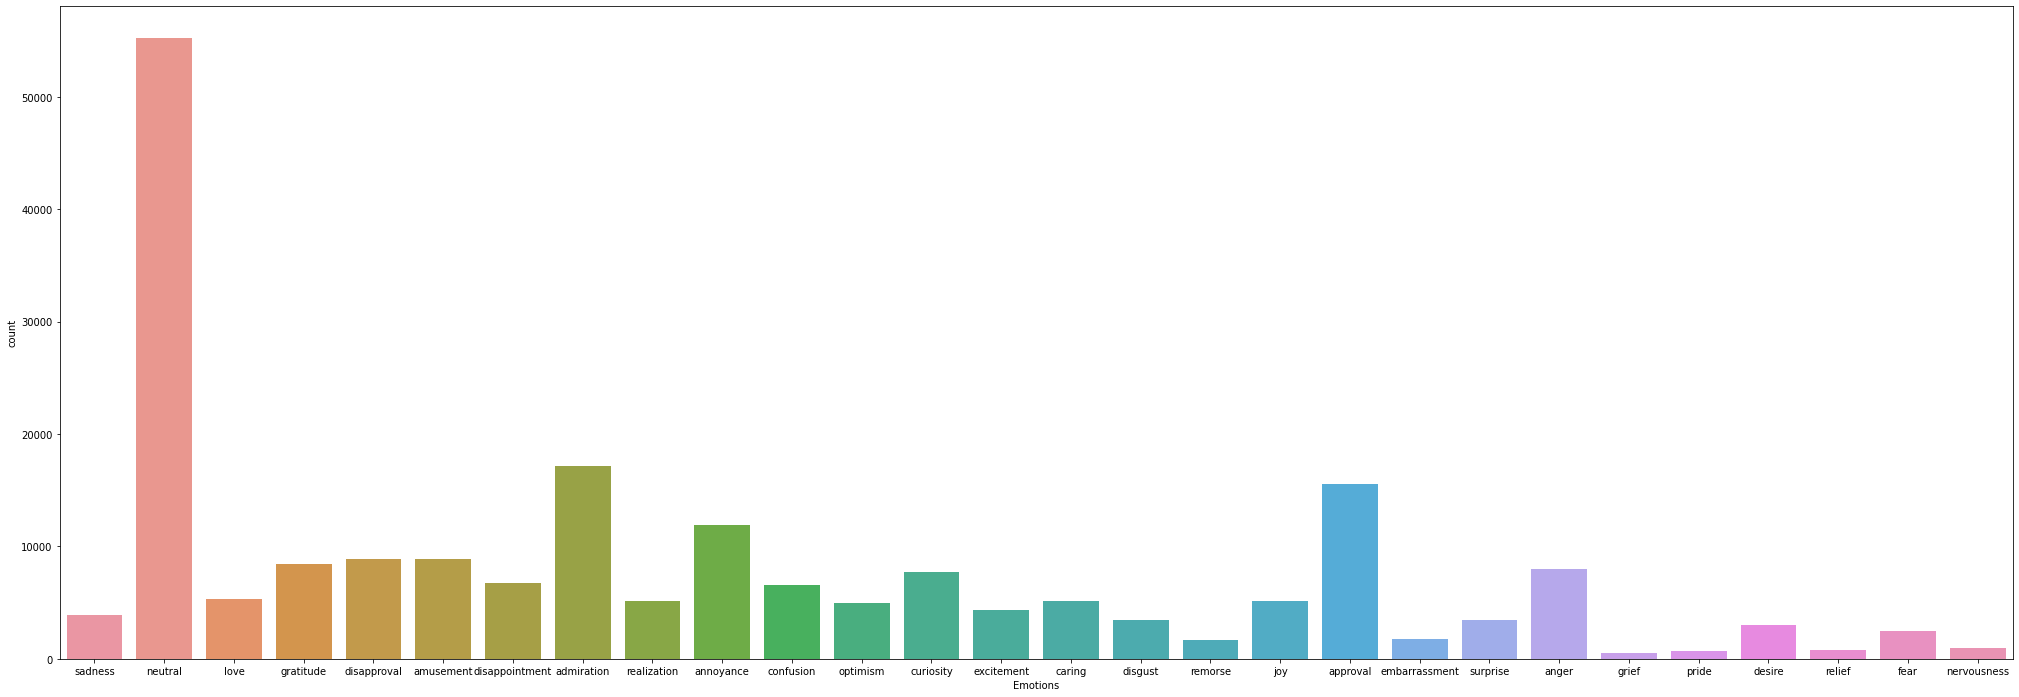

In [5]:
rcParams['figure.figsize'] = 35, 12
sns.countplot(emoji_updated2.Emotions)

In [6]:
emoji_updated2.groupby('Emotions').count()

,Sentences
Emotions,
admiration,17131
amusement,8862
anger,7956
annoyance,11929
approval,15530
caring,5147
confusion,6600
curiosity,7707
desire,3002


In [7]:
class_names = emoji_updated2.Emotions.unique()
values = np.arange(28)
dictionary_emo_val = dict(zip(values, class_names))
dictionary_val_emo = dict(zip(class_names, values))
emoji_updated3 = emoji_updated2.replace(dictionary_val_emo)

In [8]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
MAX_LEN = 150

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [9]:
class EmojiDataset(Dataset):

  def __init__(self, sentences, targets, tokenizer, max_len):
    self.sentences = sentences
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.sentences)
  
  def __getitem__(self, item):
    review = str(self.sentences[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = EmojiDataset(
    sentences=df.Sentences.to_numpy(),
    targets=df.Emotions.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.1)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [10]:
df_train, df_test = train_test_split(emoji_updated3, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(emoji_updated3, test_size=0.5, random_state=RANDOM_SEED)
df_train.shape, df_val.shape, df_test.shape

((187032, 2), (103907, 2), (103907, 2))

In [11]:
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [12]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
bert_model.config.hidden_size

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


768

In [13]:
model = SentimentClassifier(len(class_names))
model = model.to(device)
EPOCHS = 20
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  ) 

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/20
----------
Train loss 1.9926980245511077 accuracy 0.41537277043500576
Val   loss 1.7169419834391717 accuracy 0.4717199033751336

Epoch 2/20
----------
Train loss 1.7779200860024313 accuracy 0.45506651268232173
Val   loss 1.5472381829940145 accuracy 0.5090802352103323

Epoch 3/20
----------
Train loss 1.6357884158019431 accuracy 0.4861681423499722
Val   loss 1.4251792516407369 accuracy 0.5375961196069563

Epoch 4/20
----------
Train loss 1.495021925666477 accuracy 0.5181787073869712
Val   loss 1.3349882661470365 accuracy 0.5563051574966076

Epoch 5/20
----------
Train loss 1.3568419653167063 accuracy 0.5529374652465888
Val   loss 1.3038854470429189 accuracy 0.5608669290808127

Epoch 6/20
----------
Train loss 1.2206225531645776 accuracy 0.5902465888190256
Val   loss 1.311281507383685 accuracy 0.5621276718604137

Epoch 7/20
----------
Train loss 1.093178045701226 accuracy 0.6278658197527696
Val   loss 1.3639616744749081 accuracy 0.5555256142512054

Epoch 8/20
----------
Train 

In [16]:
model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.47029555275390494

In [18]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [19]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [20]:
print(classification_report(y_test, y_pred, target_names=class_names))

                precision    recall  f1-score   support

       sadness       0.37      0.38      0.38      1990
       neutral       0.61      0.52      0.56     27509
          love       0.51      0.71      0.60      2632
     gratitude       0.72      0.69      0.71      4190
   disapproval       0.36      0.40      0.38      4491
     amusement       0.58      0.71      0.64      4459
disappointment       0.29      0.31      0.30      3367
    admiration       0.55      0.67      0.61      8536
   realization       0.28      0.23      0.25      2578
     annoyance       0.33      0.25      0.28      5945
     confusion       0.40      0.40      0.40      3349
      optimism       0.41      0.36      0.39      2507
     curiosity       0.46      0.44      0.45      3799
    excitement       0.40      0.29      0.34      2196
        caring       0.37      0.43      0.40      2585
       disgust       0.33      0.36      0.35      1683
       remorse       0.45      0.45      0.45  